In [113]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [109]:
def load_data(path, dtype):
    return np.load(path).astype(dtype)

In [110]:
path_processed_data = '../../examples/box_w_aggr/data/processed/'

path_input = os.path.join(path_processed_data, 'input.npy')
path_target = os.path.join(path_processed_data, 'target.npy')
path_class_names = os.path.join(path_processed_data, 'class_names.npy')

inputs = load_data(path_input, 'float32')
targets = load_data(path_target, 'float32')
class_names = load_data(path_class_names, str)

In [114]:
pd.Series(class_names).value_counts()

radius_25_30    18
radius_20_25    17
radius_30_35    16
radius_35_40    15
radius_40_45    13
radius_45_50    11
dtype: int64

In [116]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
    inputs, 
    targets, 
    test_size=0.2,
    stratify=class_names,
    random_state=1)

inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape

((72, 128, 128, 5), (72, 128, 128, 2), (18, 128, 128, 5), (18, 128, 128, 2))

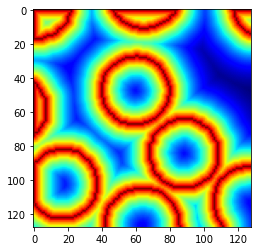

In [119]:
plt.imshow(inputs_train[3, ..., 0], cmap='jet')

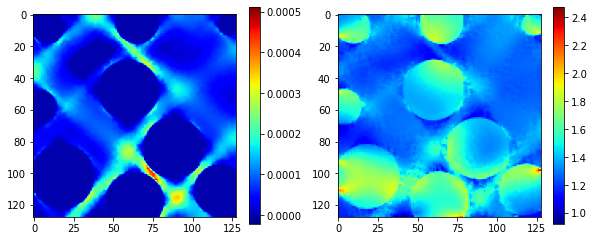

In [118]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(targets_train[3, ..., 0], cmap='jet')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(targets_train[3, ..., 1], cmap='jet')
plt.colorbar()

In [39]:
def scale(target, weight):
    target = np.where(target<0, np.zeros_like(target), target)
    target[..., 0] = target[..., 0] * weight
    return target

In [45]:
targets_train = scale(targets_train, 1e4)
targets_test = scale(targets_test, 1e4)

In [46]:
def make_dataset(inputs, targets, batch_size, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
    if is_train: dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    return dataset

In [47]:
dataset_train = make_dataset(inputs_train, targets_train, 16, is_train=True)
dataset_test = make_dataset(inputs_test, targets_test, 16)

In [48]:
for i, t in dataset_train.take(5):
    print(i.shape)
    print(t.numpy().min(), t.numpy().max())
    print()

(16, 128, 128, 5)
0.0 6.0586424

(16, 128, 128, 5)
0.0 6.151864

(16, 128, 128, 5)
0.0 5.601355

(16, 128, 128, 5)
0.0 9.278977

(16, 128, 128, 5)
0.0 5.6303244



In [49]:
class GoogleNetLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', autocast=False, **kwargs):
        super(GoogleNetLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.conv1 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[0], **default_params)
        self.conv2 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[1], **default_params)
        self.conv3 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        c2 = self.conv1(inputs)
        c3 = self.conv1(inputs)
        return self.concat([c1, c2, c3])

In [50]:
class GoogleNetTransposedLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', **kwargs):
        super(GoogleNetTransposedLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.convt1 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[0], **default_params)
        self.convt2 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[1], **default_params)
        self.convt3 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.convt1(inputs)
        c2 = self.convt1(inputs)
        c3 = self.convt1(inputs)
        return self.concat([c1, c2, c3])

In [51]:
class UnetModel(tf.keras.Model):
    def __init__(self, kernel_sizes, filter_sizes, n_output_fields):
        super(UnetModel, self).__init__()
        self.d1_layer = GoogleNetLayer(filter_sizes[0], kernel_sizes, strides=(1,1), name='d1')
        self.d2_layer = GoogleNetLayer(filter_sizes[1], kernel_sizes, strides=(2,2), name='d2')
        self.d3_layer = GoogleNetLayer(filter_sizes[2], kernel_sizes, strides=(1,1), name='d3')
        self.d4_layer = GoogleNetLayer(filter_sizes[3], kernel_sizes, strides=(2,2), name='d4')

        self.u4_layer = GoogleNetTransposedLayer(filter_sizes[3], kernel_sizes, strides=(1,1), name='u4')
        self.u3_layer = GoogleNetTransposedLayer(filter_sizes[2], kernel_sizes, strides=(2,2), name='u3')
        self.u2_layer = GoogleNetTransposedLayer(filter_sizes[1], kernel_sizes, strides=(1,1), name='u2')
        self.u1_layer = GoogleNetTransposedLayer(filter_sizes[0], kernel_sizes, strides=(2,2), name='u1')

        self.u0_layer = tf.keras.layers.Conv2D(n_output_fields, (1,1), activation='linear', padding='same', name='u1')

        self.concat1 = tf.keras.layers.Concatenate()
        self.concat3 = tf.keras.layers.Concatenate()

    def call(self, inputs):
        d1 = self.d1_layer(inputs)
        d2 = self.d2_layer(d1)
        d3 = self.d3_layer(d2)
        d4 = self.d4_layer(d3)

        u4 = self.u4_layer(d4)
        u3 = self.u3_layer(u4)
        c3 = self.concat3([u3, d3])
        u2 = self.u2_layer(c3)
        u1 = self.u1_layer(u2)
        c1 = self.concat1([u1, d1])

        return self.u0_layer(c1)

In [52]:
def get_compiled_UnetModel(kernel_sizes, filter_sizes, input_shape, n_output_fields, learning_rate):
    model = UnetModel(kernel_sizes, filter_sizes, n_output_fields)
    model.build(input_shape)

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(
        loss='mean_absolute_error',  # mean_squared_error
        optimizer=optimizer, 
        metrics=['mean_squared_error']
    ) 
    return model

In [77]:
kernel_sizes = [(7,7), (17,17), (21,21)]
filter_sizes = [4, 8, 16, 32]
input_shape = (None, 400, 400, 5)
n_output_field = 2

learning_rate = 1e-3

model = get_compiled_UnetModel(kernel_sizes, filter_sizes, input_shape, n_output_field, learning_rate)

model.summary()

Model: "unet_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d1 (GoogleNetLayer)          multiple                  984       
_________________________________________________________________
d2 (GoogleNetLayer)          multiple                  4712      
_________________________________________________________________
d3 (GoogleNetLayer)          multiple                  18832     
_________________________________________________________________
d4 (GoogleNetLayer)          multiple                  75296     
_________________________________________________________________
u4 (GoogleNetTransposedLayer multiple                  150560    
_________________________________________________________________
u3 (GoogleNetTransposedLayer multiple                  75280     
_________________________________________________________________
u2 (GoogleNetTransposedLayer multiple                 

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="min",
)

In [101]:
epochs = 20

history = model.fit(
    dataset_train, 
    epochs=epochs,
    validation_data=dataset_test,
    callbacks=[early_stopping]
)

Epoch 1/20
6/6 [==============================] - 6s 1s/step - loss: 0.4046 - mean_squared_error: 0.3167 - val_loss: 0.4288 - val_mean_squared_error: 0.3077
Epoch 2/20
6/6 [==============================] - 6s 1s/step - loss: 0.4052 - mean_squared_error: 0.3144 - val_loss: 0.4000 - val_mean_squared_error: 0.2774
Epoch 3/20
6/6 [==============================] - 7s 1s/step - loss: 0.3893 - mean_squared_error: 0.3005 - val_loss: 0.3715 - val_mean_squared_error: 0.2739
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.3792 - mean_squared_error: 0.2861 - val_loss: 0.3626 - val_mean_squared_error: 0.2577
Epoch 5/20
6/6 [==============================] - 7s 1s/step - loss: 0.3698 - mean_squared_error: 0.2700 - val_loss: 0.3782 - val_mean_squared_error: 0.2863
Epoch 6/20
6/6 [==============================] - 7s 1s/step - loss: 0.3794 - mean_squared_error: 0.2762 - val_loss: 0.3541 - val_mean_squared_error: 0.2420
Epoch 7/20
6/6 [==============================] - 7s 1s/st

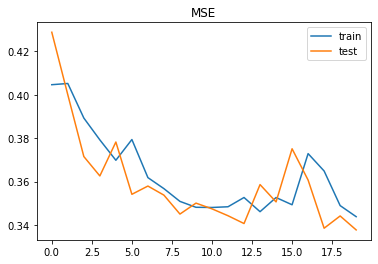

In [102]:
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='test')
plt.title('MSE')
plt.legend()

In [103]:
path = 'test_saved_model'
model.save(path)

INFO:tensorflow:Assets written to: test_saved_model/assets
INFO:tensorflow:Assets written to: test_saved_model/assets


In [104]:
def plot_example(target, pred):
    vmax = min(np.max(pred), np.max(target))
    vmin = 0

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
    ax0.imshow(np.squeeze(target), vmin=vmin, vmax=vmax, cmap='seismic')
    ax0.set_title('target')

    im = ax1.imshow(np.squeeze(pred), vmin=vmin, vmax=vmax, cmap='seismic')
    ax1.set_title('prediction')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax=cbar_ax)

In [105]:
dataset = make_dataset(inputs_test, targets_test, 1)
pred = model.predict(dataset)

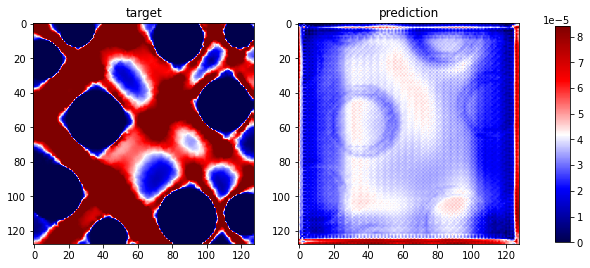

In [106]:
idx = 5
plot_example(targets_test[idx, ..., 0]*1e-4, pred[idx, ..., 0]*1e-4)

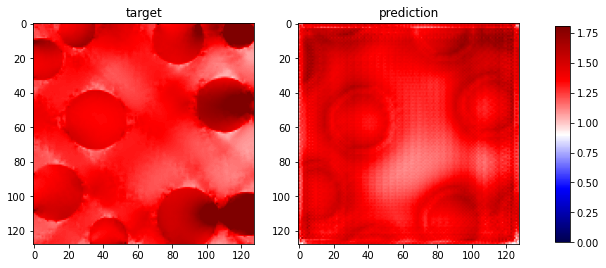

In [107]:
plot_example(targets_test[idx, ..., 1], pred[idx, ..., 1])